In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import os
from PIL import Image

from Config import Config
from Models import Tools, PreTrainedKPD

In [97]:
#Get csv files into dataframes
notes = pd.read_csv('CSVs/combined.csv')
preds = pd.read_csv('predictions_17december.csv')

#Get rid of extension name for some unmatch with jpg
preds['Image Name'] = preds['Image Name'].map(lambda s : os.path.splitext(s)[0])
notes['Image Name'] = notes['Image Name'].map(lambda s : os.path.splitext(s)[0])

#Get rid of duplicate annotation of the same image
notes = notes.groupby(['Image Name']).mean()

In [98]:
# match annotated coordinates with predicted ones using sql like inner join on column Image Name
df = preds.set_index('Image Name').join(notes, how='inner', lsuffix='_predicted', rsuffix='_real')

In [99]:
"""
it is finally not necessary to normalize here?
"""

#function to get images dimension for normalisation
#for combined and prediction are on the same original scale
def get_image_shape(file_path):
    with Image.open(file_path) as img:
        return img.size


shapes  = df.index.map(lambda s : get_image_shape(
    os.path.join(Config.images_folder_path, s + '.png')
    )
).to_frame( index=False,name=['X','Y']).values

df['X'] = shapes[:,0]
df['Y'] = shapes[:,1]

#Normalizing columns, also the heigt and width are note 
df = df.assign(
    x1_predicted=lambda d: d['x1_predicted'] / d['X'],
    y1_predicted=lambda d: d['y1_predicted'] / d['Y'],
    x2_predicted=lambda d: d['x2_predicted'] / d['X'],
    y2_predicted=lambda d: d['y2_predicted'] / d['Y'],
    x1_real=lambda d: d['x1_real'] / d['X'],
    y1_real=lambda d: d['y1_real'] / d['Y'],
    x2_real=lambda d: d['x2_real'] / d['X'],
    y2_real=lambda d: d['y2_real'] / d['Y'], 
).drop(['X','Y'], axis=1)

In [100]:
"""
Compute of distance error the same as the confidence model prediction was trained
but not on the real distance error of the KPD but on the distance error from annotations
"""
keypoints = torch.tensor(df[['x1_predicted','y1_predicted','x2_predicted','y2_predicted']].values)
outputs = torch.tensor(df[['x1_real','y1_real','x2_real','y2_real']].values)

clamp_threshold = 0.004

errors = (keypoints - outputs)**2
mse_per_vector = torch.mean(errors, dim=1, keepdim=True)
mse_per_vector_np = mse_per_vector.cpu().numpy()

# Step 1: Normalize by mean and variance
mean = mse_per_vector.mean()
std = mse_per_vector.std()
normalized_vector = (mse_per_vector - mean) / std

min_val = normalized_vector.min()
max_val = normalized_vector.max()

scaled_errors = (normalized_vector - min_val) / (max_val - min_val)

df['Error scale'] = scaled_errors

print(f"MSE loss {torch.nn.MSELoss()(outputs, keypoints)}")
print(f"Tools.py distance loss (normalized?) {Tools.get_distance_loss(outputs, keypoints)}")

MSE loss 0.045702337944739976
Tools.py distance loss (normalized?) 0.12729763552053083


In [101]:
print(f"The error mean is {df['Error scale'].mean()}")
print(f"The error variance is {df['Error scale'].var()}")
print(f"The error mean given the confidence is { (df['Error scale'] * df['Error estimate']).sum() / df['Error scale'].sum()}")

The error mean is 0.26820112739373847
The error variance is 0.010187071145561702
The error mean given the confidence is 0.2982082624144184


In [102]:
# Dataframe of the evolution metrics during the training of kpd model for pre-training and fine-tuning
#This has been processed from the printings of Tools.train_kpd_model() in Training.ipynb

pretrain_loss = pd.DataFrame({
    'Epoch': [0, 50, 100, 150, 200, 250, 300, 350, 400],
    'Test Loss': [
        0.21656227111816406, 0.017515307292342186, 0.007022107020020485,
        0.005836768541485071, 0.004943563137203455, 0.004706777632236481,
        0.004554087296128273, 0.004576138220727444, 0.004430223256349564
    ],
    'Learning Rate': [
        9.900000000000001e-05, 5.9895600646616125e-05, 3.62372017860497e-05,
        2.1923726936647233e-05, 1.326398781093821e-05, 8.024793100055947e-06,
        4.855048513057286e-06, 2.9373338066467324e-06, 1.7771047742294685e-06
    ],
    'Distance Error': [
        0.11020448803901672, 0.1394646316766739, 0.09164484590291977,
        0.08644966036081314, 0.07801023870706558, 0.07784640789031982,
        0.07664965093135834, 0.07855602353811264, 0.07483527064323425
    ]
})

# finetuning after pretraining
finetune_loss = pd.DataFrame({
    'Epoch': [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    'Test Loss': [
        0.005645541939884424, 0.002760204952210188, 0.0026814809534698725,
        0.001673800521530211, 0.001656909822486341, 0.0014939593384042382,
        0.0014554103836417198, 0.0014774646842852235, 0.0014525195583701134,
        0.0014160911086946726, 0.0014338785549625754
    ],
    'Learning Rate': [
        9.900000000000001e-05, 5.9895600646616125e-05, 3.62372017860497e-05,
        2.1923726936647233e-05, 1.326398781093821e-05, 8.024793100055947e-06,
        4.855048513057286e-06, 2.9373338066467324e-06, 1.7771047742294685e-06,
        1.0751591703479103e-06, 6.50477821199046e-07
    ],
    'Distance Error': [
        0.07057426869869232, 0.04805443435907364, 0.06100216880440712,
        0.04197042062878609, 0.04451345279812813, 0.04131276160478592,
        0.041651103645563126, 0.04155052453279495, 0.041379883885383606,
        0.04106401279568672, 0.04186074808239937
    ]
})

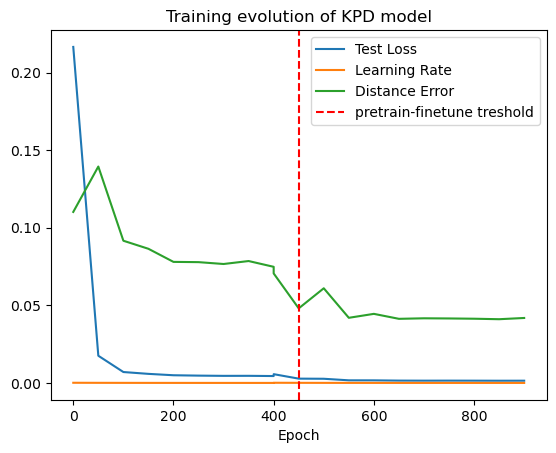

In [103]:
#shift
finetune_loss['Epoch'] += pretrain_loss['Epoch'].iloc[-1]
#concat finetune after pretrain
train = pd.concat([pretrain_loss.set_index('Epoch'), finetune_loss.set_index('Epoch')])
#plot
ax = train.plot(title='Training evolution of KPD model', xlabel='Epoch')
ax.axvline(x=450, color='red', ls='--', label="pretrain-finetune treshold")
ax.legend()